# Keras and JAX: The vectorization problem

The integration of Keras and JAX is usually done in a seamless way through the Keras high-level API. In the situations where it is necessary to specifically use the JAX API, the typical use case is to exploit the advanced autodiff capabilities of JAX on a scalar-valued loss function. $L: \mathbb{R}^{k\times n} \to \mathbb{R}$, where $n$ is the dimensionality of the input and $k$ is the number of samples in each data batch. In general, `jax.grad` is sufficient, and everything fits together smoothly.

However, things gets trickier when we move to more advanced differentiation scenarios. For example, if we want to differentiate the model itself, and not just a loss function, there is a fundamental mismatch between the two frameworks:
 - JAX works **by default with single-sample scalar functions** $f_{JAX}: \mathbb{R}^n \to \mathbb{R}$, that can be subsequently composed or vectorized by means of `jax.vmap()` to build batched and/or vector-valued functions: $f: \mathbb{R}^{k \times n} \to \mathbb{R}^m$.
 - Keras models **are always vectorized**, in the sense that they require an input of the form $f_{Keras}:\mathbb{R}^{k \times n} \to \mathbb{R}^k$. For single samples, $k=1$, but this dimension needs to be present.

This inconsistency leads to technical issues when we want to play with derivatives of Keras models in JAX. As an example, let's start with a basic Keras model $model : \mathbb{R}^{k \times 3} \to \mathbb{R}^{20}$.

In [91]:
import numpy as np, jax, os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import jax.numpy as jnp

INPUT_DIM = 3 # Sample input size (n)
OUTPUT_DIM = 20 # Output size (m)

model = keras.Sequential([
 keras.layers.Input(shape=(INPUT_DIM,)),
 keras.layers.Dense(50, activation="tanh"),
 keras.layers.Dense(50, activation="tanh"),
 keras.layers.Dense(OUTPUT_DIM, activation="tanh")
])

If we create a single input sample, and try to apply it to the model, we get an error, since the batch dimension is missing:

In [99]:
x = np.random.normal(size=[INPUT_DIM])
print(f'Input shape: {x.shape}')
model(x)

Input shape: (3,)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [ 1.2783152  -0.00506101 -0.26067215]. Expected shape (None, 3), but input has incompatible shape (3,)[0m

Arguments received by Sequential.call():
  • inputs=jnp.ndarray(shape=(3,), dtype=float32)
  • training=None
  • mask=None

In order to make it work, we need to extend the dimensionality of the input, so the sample becomes a batch with $k=1$. Then we can successfully run the model:

In [100]:
x_batched = x[None, :]
print(f'Input shape: {x_batched.shape}')
model(x_batched)

Input shape: (1, 3)


Array([[-0.16134535, -0.3573506 ,  0.15069897,  0.14801544,  0.07621031,
        -0.14487216,  0.26420867, -0.33378848, -0.0762703 , -0.08013102,
         0.13615738,  0.08436324,  0.14981805,  0.01989664, -0.10104934,
         0.21473293, -0.25664064, -0.02787009,  0.26199204,  0.01821427]],      dtype=float32)

Now, let's assume we want to calculate the derivatives of the model with respect to the inputs (a.k.a, the Jacobian matrix). In principle, JAX provides this functionality with both forward- and reverse-mode differentiation (`jacfwd` and `jacrev`). Let's try the forward mode:

In [103]:
dmodel_fwd = jax.jacfwd(model)
jac = dmodel_fwd(x_batched)
print(f'Jacobian shape: {jac.shape}')
print(jac)

Jacobian shape: (1, 20, 1, 3)
[[[[-0.10386763  0.22971387 -0.02748211]]

  [[-0.13561358  0.02511462  0.4059095 ]]

  [[ 0.08118173  0.09519719 -0.1493624 ]]

  [[ 0.12117666  0.14483635  0.04284788]]

  [[ 0.03144521  0.15269451 -0.14726011]]

  [[-0.10088737 -0.08795802  0.02256933]]

  [[ 0.15823878  0.20095421 -0.03686984]]

  [[-0.15419677 -0.03500504  0.2711907 ]]

  [[-0.03264001 -0.08267692  0.08948411]]

  [[-0.05499518  0.05186022 -0.02160137]]

  [[ 0.07560223 -0.14713572 -0.12391873]]

  [[ 0.0336221   0.17222449  0.0114738 ]]

  [[ 0.08883565 -0.06098349 -0.03416364]]

  [[ 0.09981303  0.17546794  0.38933516]]

  [[-0.11384796  0.00410432 -0.20641732]]

  [[ 0.18840988  0.13945931  0.15969786]]

  [[-0.15185542  0.0496636   0.07724226]]

  [[ 0.05032565 -0.00925323  0.36256856]]

  [[ 0.2033434   0.3477383   0.15709555]]

  [[-0.00472036 -0.0911383  -0.06758498]]]]


Ideally, we would expect a $20 \times 3$ matrix, but we see there are two extra dimensions for the input and output batches. Still, all the data in this matrix is relevant, so not a big deal. Dimensions can be solved just with a `squeeze()` call. However, if we create a batch with several samples (e.g., $k=4$):

In [104]:
x_batched = np.random.normal(size=[4, INPUT_DIM])
jac = dmodel_fwd(x_batched)
print(f'Jacobian shape: {jac.shape}')
print(jac)

Jacobian shape: (4, 20, 4, 3)
[[[[-1.35208249e-01  2.05792353e-01  1.49450693e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[-1.57755136e-01  4.95194681e-02  4.19473916e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 5.78335896e-02  5.55242859e-02 -1.39869973e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 1.10367060e-01  1.31753743e-01  5.97605892e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[-3.14685865e-03  1.44366562e-01 -1.34699509e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.0

We see that the gradients are also calculated between the samples of the batch (which are obviously always 0). This results in a tensor that is $k$ times larger than necessary, which is extremely unefficient, particularly for large batches. A sum over the first axis would give the correct result, but it is indeed a very unsatisfying solution from the point of view of efficiency and code clarity.

## Solution: Unbatching Keras models

The simplest solution comes from adapting Keras models to meets JAX expectations, that is, removing the batch dimension from the input and output. This is done with a thin wrapper function over any keras model:

In [108]:
def model_unbatched(x):
    """Unbatched interface for a keras model, assuming a single input."""
    return model(x[None,:]).squeeze()

#This function works properly with the single sample that failed with the original Keras model
print(model_unbatched(x))

[-0.16134535 -0.3573506   0.15069897  0.14801544  0.07621031 -0.14487216
  0.26420867 -0.33378848 -0.0762703  -0.08013102  0.13615738  0.08436324
  0.14981805  0.01989664 -0.10104934  0.21473293 -0.25664064 -0.02787009
  0.26199204  0.01821427]


There is, however, a risk that this unbatched version results in a much lower performance when applied to large batches of samples. Let's do a quick comparison between calling the original model and calling the unbatched model over a large number of samples by means of `jax.vmap()`:

In [116]:
x_batched_big = jnp.array(np.random.normal(size=[10000, INPUT_DIM]))

%timeit model(x_batched_big).block_until_ready()

2.98 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [115]:
model_rebatched = jax.jit(jax.vmap(model_unbatched))
%timeit model_rebatched(x_batched_big).block_until_ready()

2.39 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The performance is indeed **better**! So it is safe to work with `model_unbatched` from now on. Let's calculate the Jacobian as before, and check that dimensions fit properly.

In [118]:
dmodel_fwd = jax.jacfwd(model_unbatched)
jac = dmodel_fwd(x)
print(f'Jacobian shape: {jac.shape}')
print(jac)

Jacobian shape: (20, 3)
[[-0.10386763  0.22971387 -0.02748211]
 [-0.13561358  0.02511462  0.4059095 ]
 [ 0.08118173  0.09519719 -0.1493624 ]
 [ 0.12117666  0.14483635  0.04284788]
 [ 0.03144521  0.15269451 -0.14726011]
 [-0.10088737 -0.08795802  0.02256933]
 [ 0.15823878  0.20095421 -0.03686984]
 [-0.15419677 -0.03500504  0.2711907 ]
 [-0.03264001 -0.08267692  0.08948411]
 [-0.05499518  0.05186022 -0.02160137]
 [ 0.07560223 -0.14713572 -0.12391873]
 [ 0.0336221   0.17222449  0.0114738 ]
 [ 0.08883565 -0.06098349 -0.03416364]
 [ 0.09981303  0.17546794  0.38933516]
 [-0.11384796  0.00410432 -0.20641732]
 [ 0.18840988  0.13945931  0.15969786]
 [-0.15185542  0.0496636   0.07724226]
 [ 0.05032565 -0.00925323  0.36256856]
 [ 0.2033434   0.3477383   0.15709555]
 [-0.00472036 -0.0911383  -0.06758498]]


Now we can vectorize the Jacobian function, and get "clean" derivatives over batches:

In [119]:
dmodel_fwd_batched = jax.jit(jax.vmap(dmodel_fwd))
jac = dmodel_fwd_batched(x_batched)
print(f'Jacobian shape: {jac.shape}')
print(jac)

Jacobian shape: (4, 20, 3)
[[[-1.35208234e-01  2.05792353e-01  1.49450675e-02]
  [-1.57755151e-01  4.95194681e-02  4.19473946e-01]
  [ 5.78335822e-02  5.55242933e-02 -1.39869973e-01]
  [ 1.10367075e-01  1.31753758e-01  5.97605743e-02]
  [-3.14684864e-03  1.44366577e-01 -1.34699523e-01]
  [-9.53039154e-02 -6.34610429e-02 -1.12814521e-02]
  [ 1.39689907e-01  1.42116025e-01 -2.87780017e-02]
  [-1.56073391e-01 -1.39225600e-02  2.79139966e-01]
  [-1.28948363e-02 -4.36041914e-02  8.82110521e-02]
  [-7.25248680e-02  5.81447929e-02 -2.11735945e-02]
  [ 6.25397414e-02 -1.31279394e-01 -1.24243781e-01]
  [ 5.65703101e-02  1.27951294e-01  2.24409960e-02]
  [ 9.41580981e-02 -6.90289959e-02 -3.46729532e-02]
  [ 8.66942704e-02  1.62410080e-01  3.61143351e-01]
  [-1.18553653e-01 -1.82670560e-02 -1.77160397e-01]
  [ 1.39961451e-01  1.16369396e-01  1.59718081e-01]
  [-1.73956603e-01  1.01550825e-01  8.25091079e-02]
  [ 5.77741265e-02 -1.20793227e-02  3.62038374e-01]
  [ 1.42615169e-01  2.01915741e-01  1

We can check also the performance of the batched jacobian function, which ends up being decent:

In [126]:
%timeit dmodel_fwd_batched(x_batched_big).block_until_ready()

4.27 ms ± 94.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Integration in the training loop:

Conceptually the solution explored is simple and efficient, but in practice, if we want to calculate the derivatives of a model **within the training loop**, we need to take into account some performance issues when working directly with Keras models. Specifically, in the JAX backend, the model's variables are not directly updated in the main object on every iteration, but only the tuple of tensors [gets updated in a stateless manner](https://keras.io/guides/custom_train_step_in_jax/). You may find a complete example of a reference implementation below, with the same network architecture of the `model` we have used so far:

In [233]:
class CustomModel(keras.Model):
    
    def __init__(self, **kwargs):
        super().__init__()

        self.layer_list = [
            keras.layers.Dense(50, activation="tanh"),
            keras.layers.Dense(50, activation="tanh"),
            keras.layers.Dense(OUTPUT_DIM, activation="tanh")
        ]

    def call(self, inputs):
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

    def compute_loss_and_updates(self, trainable_vars, non_trainable_vars, metrics_vars, 
                                 x, y, sample_weight, training=False, optimizer_variables=None):

        def unbatched_stateless_call(x):
            """
            Convenient wrapper function to calculate derivatives with respect to non-batched
            input samples.
            """
            y_pred, _ = self.stateless_call(trainable_vars, non_trainable_vars, x[None, :])
            return y_pred.squeeze()

        #Function to calculate the jacobian of the model with respect to the input (batched).
        dmodel_fwd_batched = jax.jit(jax.vmap(jax.jacfwd(unbatched_stateless_call)))
        
        u, _ = self.stateless_call(trainable_vars, non_trainable_vars, x)
        du_dx = dmodel_fwd_batched(x)
        residual = jnp.sum(du_dx, axis=2) + u
        loss = jnp.mean(jnp.square(residual))

        return loss, (loss, u, non_trainable_vars, metrics_vars)                               
        
        

In [234]:
cmodel = CustomModel()
cmodel.compile(optimizer='Adam', run_eagerly=False)

In [235]:
history = cmodel.fit(x_batched_big, batch_size=100, epochs=100)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0461  
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 5.9893e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2804e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 1.9353e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 1.3087e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 9.4177e-05
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 6.7945e-05
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 4.9836e-05
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 4.0049e-05
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 3.3549e-05
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 2.8555e-05
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 2.2673e-05
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 2.1126e-05
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━

Text(0.5, 1.0, 'Loss evolution')

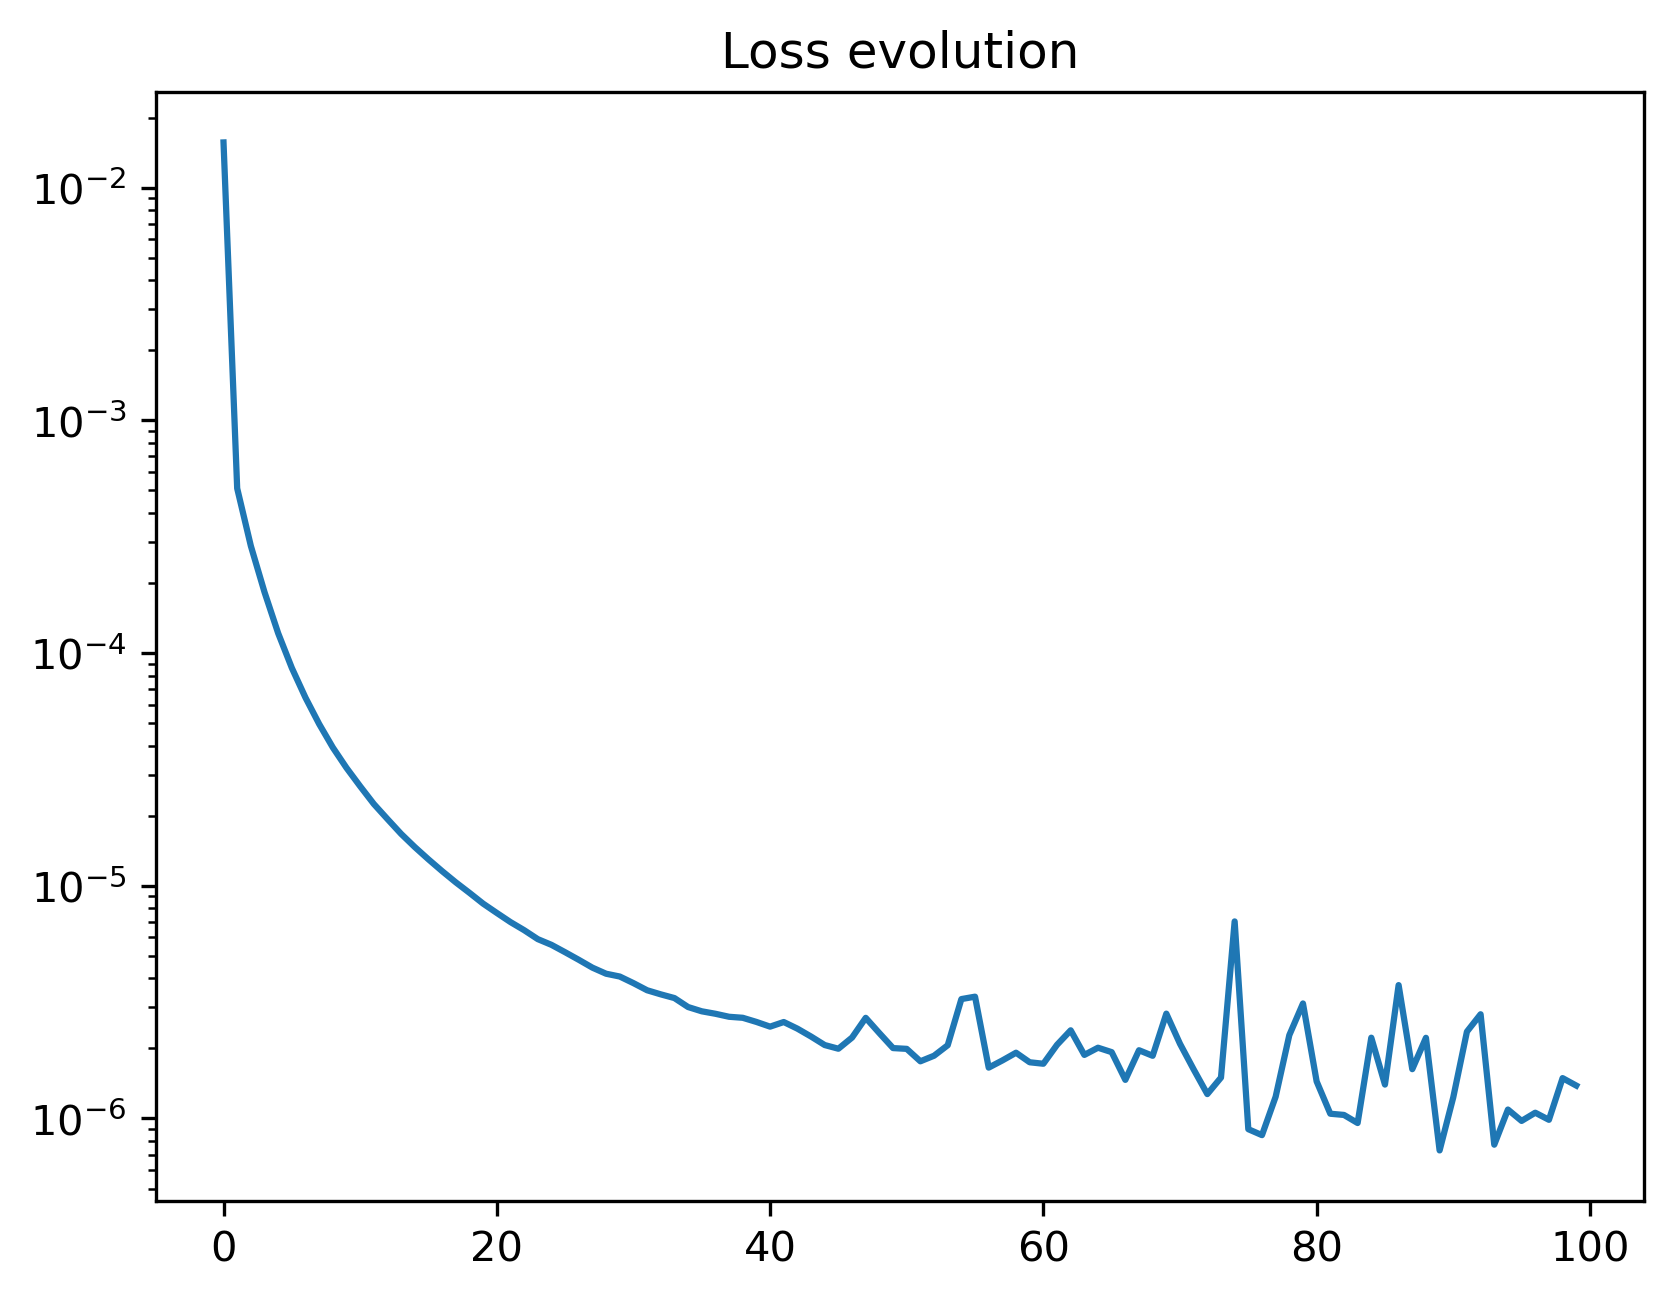

In [236]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.yscale('log')
plt.title('Loss evolution')